### Работу выполнил Данил Исламов (Danil_Islamoff_274397404)

### 1. Импортируем все необходимые библиотеки и загружаем данные

In [ ]:
!pip install pretrainedmodels

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

import pretrainedmodels


Проверяем, что GPU доступен

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Dec  1 16:59:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   3123MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Подгружаем с диска данные

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!unzip -q /content/gdrive/MyDrive/DLS_Kaggle_2_CNN/journey-springfield.zip -d data

replace data/characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!ls data

characters_illustration.png  sample_submission.csv  testset  train


### 2. Готовим данные к работе

In [ ]:
# Режимы, в которых будут обрабатываться датасеты 
DATA_MODES = ['train', 'val', 'test']
# Масштабирование к размеру 224x224 px
RESCALE_SIZE = 224
# Работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который будет параллельно подгружать их из папок
    и обрабатывать заданным образом
    """
    def __init__(self, files, mode):
        super().__init__()
        # Список файлов для загрузки
        self.files = sorted(files)
        # Режим работы
        self.mode = mode

        # Проверяем, что задан корректный режим работы
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        # Учим LabelEncoder кодировать метки классов датасета для обучающей и 
        # валидационной выборки
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    # Загружаем картинку
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    # Получаем картинку и обрабатываем её перед тем, как передать в модель
    def __getitem__(self, index):
        
        # Переводим картинки в тензор, нормализуем их. Аугментируем в случае
        # работы с обучающей выборкой
        if self.mode == 'train':
          transform = transforms.Compose([ 
              transforms.ToTensor(),
              transforms.ColorJitter(),
              transforms.RandomRotation(degrees=30),                          
              transforms.RandomHorizontalFlip(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        else: 
          transform = transforms.Compose([ 
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    # Приводим картинку к нужному размеру
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
# Отрисовываем картинку из датасета
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Задаём тренировочные и валидационные файлы

In [ ]:
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

Проверяем, что файлы нормально загружаются и размечаются

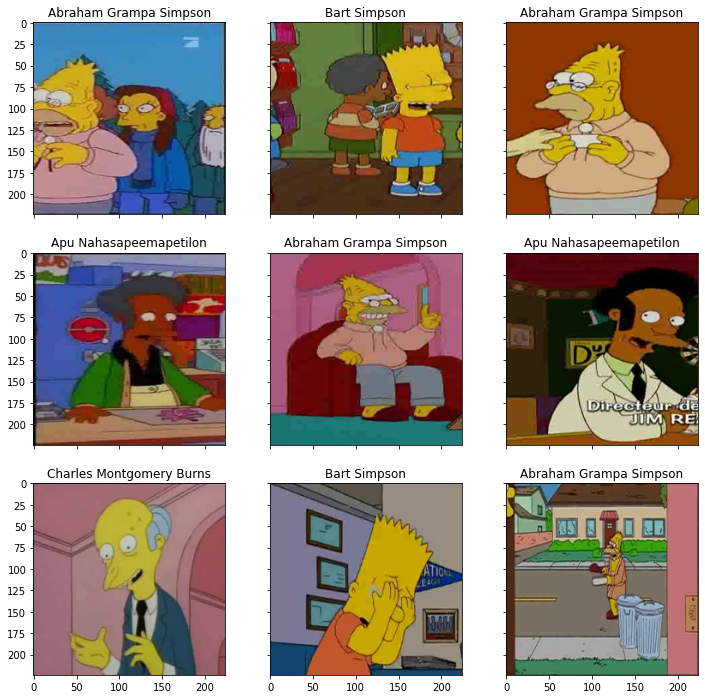

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### 3. Обучаем модель

In [ ]:
# Загружаем предобученную ResNet50
model = pretrainedmodels.__dict__['resnet50'](num_classes=1000, pretrained='imagenet')

In [ ]:
# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False

# Меняем последний полносвязный слой, чтобы он подходил для нашей задачи
model.last_linear = nn.Linear(in_features=2048, out_features=len(np.unique(train_val_labels)))

# Размораживаем BottleNecks последнего слоя
for i in range(2):
    for param in model.layer4[i].parameters():
        param.requires_grad = True

In [ ]:
# Отправляем модель на GPU
model.to(DEVICE)
None

In [ ]:
# Обучение модели на одной эпохе; возвращает значение лосса и accuracy
# по обучающему датасету на данной эпохе
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
# Валидация на одной эпохе; возвращает значение лосса и accuracy по
# валидационному датасету на данной эпохе
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

В данной функции реализован полный цикл обучения модели; в качестве параметров (помимо очевидных — модели и датасетов) принимает количество эпох, размер батчей, оптимизатор и функцию потерь. Во время работы выводит текущее значение лосса, accuracy на обучающей и валидационной выборке, а также номер эпохи

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, opt, criterion):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            torch.save(model.state_dict(), '/content/gdrive/MyDrive/final.pt')

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Функция, возвращающая предсказания модели на переданном датасете

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запускаем обучение сети. Мой лучший результат был достигнут с параметрами, приведёнными ниже, поэтому передаю в модель именно их

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=60, \
                batch_size=128, opt=opt, criterion=criterion)

epoch:   0%|          | 0/60 [00:00<?, ?it/s]

loss 0.7883348463238314


epoch:   2%|▏         | 1/60 [04:38<4:33:43, 278.37s/it]


Epoch 001 train_loss: 0.7883     val_loss 0.3741 train_acc 0.8115 val_acc 0.9022
loss 0.507365238864723


epoch:   3%|▎         | 2/60 [09:07<4:26:21, 275.54s/it]


Epoch 002 train_loss: 0.5074     val_loss 0.2909 train_acc 0.8694 val_acc 0.9251
loss 0.2458958294492017


epoch:   5%|▌         | 3/60 [13:31<4:18:30, 272.11s/it]


Epoch 003 train_loss: 0.2459     val_loss 0.2783 train_acc 0.9344 val_acc 0.9266
loss 0.18431520307319954


epoch:   7%|▋         | 4/60 [17:52<4:10:47, 268.70s/it]


Epoch 004 train_loss: 0.1843     val_loss 0.2222 train_acc 0.9516 val_acc 0.9448
loss 0.14509057604653022


epoch:   8%|▊         | 5/60 [22:12<4:04:00, 266.20s/it]


Epoch 005 train_loss: 0.1451     val_loss 0.2201 train_acc 0.9600 val_acc 0.9473
loss 0.11393881960065967


epoch:  10%|█         | 6/60 [26:31<3:57:43, 264.15s/it]


Epoch 006 train_loss: 0.1139     val_loss 0.1919 train_acc 0.9702 val_acc 0.9559
loss 0.10298652114898689


epoch:  12%|█▏        | 7/60 [30:52<3:52:28, 263.18s/it]


Epoch 007 train_loss: 0.1030     val_loss 0.2070 train_acc 0.9720 val_acc 0.9547
loss 0.10216095165406316


epoch:  13%|█▎        | 8/60 [35:16<3:48:14, 263.36s/it]


Epoch 008 train_loss: 0.1022     val_loss 0.1909 train_acc 0.9717 val_acc 0.9566
loss 0.07768478639306624


epoch:  15%|█▌        | 9/60 [39:39<3:43:38, 263.11s/it]


Epoch 009 train_loss: 0.0777     val_loss 0.2059 train_acc 0.9787 val_acc 0.9578
loss 0.07550381515911904


epoch:  17%|█▋        | 10/60 [44:00<3:38:51, 262.63s/it]


Epoch 010 train_loss: 0.0755     val_loss 0.2811 train_acc 0.9802 val_acc 0.9352
loss 0.0791841228318443


epoch:  18%|█▊        | 11/60 [48:22<3:34:17, 262.39s/it]


Epoch 011 train_loss: 0.0792     val_loss 0.1770 train_acc 0.9787 val_acc 0.9576
loss 0.06023865083925541


epoch:  20%|██        | 12/60 [52:42<3:29:21, 261.71s/it]


Epoch 012 train_loss: 0.0602     val_loss 0.1915 train_acc 0.9836 val_acc 0.9582
loss 0.058572683043536376


epoch:  22%|██▏       | 13/60 [57:02<3:24:32, 261.11s/it]


Epoch 013 train_loss: 0.0586     val_loss 0.1941 train_acc 0.9839 val_acc 0.9603
loss 0.05299084456519448


epoch:  23%|██▎       | 14/60 [1:01:22<3:20:00, 260.88s/it]


Epoch 014 train_loss: 0.0530     val_loss 0.1830 train_acc 0.9852 val_acc 0.9656
loss 0.04587359158695361


epoch:  25%|██▌       | 15/60 [1:05:39<3:14:48, 259.75s/it]


Epoch 015 train_loss: 0.0459     val_loss 0.2840 train_acc 0.9872 val_acc 0.9450
loss 0.043633589288620246


epoch:  27%|██▋       | 16/60 [1:10:02<3:11:06, 260.61s/it]


Epoch 016 train_loss: 0.0436     val_loss 0.1945 train_acc 0.9875 val_acc 0.9629
loss 0.035853716392760346


epoch:  28%|██▊       | 17/60 [1:14:37<3:09:49, 264.87s/it]


Epoch 017 train_loss: 0.0359     val_loss 0.2118 train_acc 0.9902 val_acc 0.9593
loss 0.043899623130882


epoch:  30%|███       | 18/60 [1:19:14<3:07:56, 268.50s/it]


Epoch 018 train_loss: 0.0439     val_loss 0.2124 train_acc 0.9876 val_acc 0.9582
loss 0.04392714481472142


epoch:  32%|███▏      | 19/60 [1:23:43<3:03:39, 268.77s/it]


Epoch 019 train_loss: 0.0439     val_loss 0.1864 train_acc 0.9876 val_acc 0.9650
loss 0.04722531060261957


epoch:  33%|███▎      | 20/60 [1:28:04<2:57:31, 266.29s/it]


Epoch 020 train_loss: 0.0472     val_loss 0.2424 train_acc 0.9868 val_acc 0.9534
loss 0.03856918453532853


epoch:  35%|███▌      | 21/60 [1:32:23<2:51:45, 264.25s/it]


Epoch 021 train_loss: 0.0386     val_loss 0.2089 train_acc 0.9885 val_acc 0.9610
loss 0.02475717489758937


epoch:  37%|███▋      | 22/60 [1:36:43<2:46:33, 262.98s/it]


Epoch 022 train_loss: 0.0248     val_loss 0.1785 train_acc 0.9930 val_acc 0.9671
loss 0.031163252076900905


epoch:  38%|███▊      | 23/60 [1:41:01<2:41:19, 261.60s/it]


Epoch 023 train_loss: 0.0312     val_loss 0.2630 train_acc 0.9912 val_acc 0.9463
loss 0.03337061312352178


epoch:  40%|████      | 24/60 [1:45:20<2:36:26, 260.72s/it]


Epoch 024 train_loss: 0.0334     val_loss 0.2131 train_acc 0.9913 val_acc 0.9601
loss 0.032244963568225773


epoch:  42%|████▏     | 25/60 [1:49:39<2:31:44, 260.13s/it]


Epoch 025 train_loss: 0.0322     val_loss 0.2214 train_acc 0.9901 val_acc 0.9660
loss 0.02674612837711127


epoch:  43%|████▎     | 26/60 [1:53:57<2:27:09, 259.68s/it]


Epoch 026 train_loss: 0.0267     val_loss 0.2612 train_acc 0.9915 val_acc 0.9570
loss 0.02328593903403017


epoch:  45%|████▌     | 27/60 [1:58:14<2:22:14, 258.61s/it]


Epoch 027 train_loss: 0.0233     val_loss 0.2230 train_acc 0.9940 val_acc 0.9585
loss 0.027428936857124574


epoch:  47%|████▋     | 28/60 [2:02:31<2:17:43, 258.24s/it]


Epoch 028 train_loss: 0.0274     val_loss 0.2755 train_acc 0.9915 val_acc 0.9461
loss 0.032034901188563926


epoch:  48%|████▊     | 29/60 [2:06:50<2:13:30, 258.41s/it]


Epoch 029 train_loss: 0.0320     val_loss 0.1846 train_acc 0.9909 val_acc 0.9689
loss 0.03301590297257722


epoch:  50%|█████     | 30/60 [2:11:10<2:09:28, 258.94s/it]


Epoch 030 train_loss: 0.0330     val_loss 0.2157 train_acc 0.9905 val_acc 0.9580
loss 0.023313108888238857


epoch:  52%|█████▏    | 31/60 [2:15:29<2:05:11, 259.02s/it]


Epoch 031 train_loss: 0.0233     val_loss 0.1892 train_acc 0.9928 val_acc 0.9626
loss 0.026991982614054742


epoch:  53%|█████▎    | 32/60 [2:19:48<2:00:50, 258.95s/it]


Epoch 032 train_loss: 0.0270     val_loss 0.2046 train_acc 0.9910 val_acc 0.9635
loss 0.02436793798605563


epoch:  55%|█████▌    | 33/60 [2:24:06<1:56:24, 258.69s/it]


Epoch 033 train_loss: 0.0244     val_loss 0.2118 train_acc 0.9924 val_acc 0.9645
loss 0.021651307852380296


epoch:  57%|█████▋    | 34/60 [2:28:25<1:52:08, 258.78s/it]


Epoch 034 train_loss: 0.0217     val_loss 0.2108 train_acc 0.9937 val_acc 0.9641
loss 0.02446757593875035


epoch:  58%|█████▊    | 35/60 [2:32:43<1:47:40, 258.42s/it]


Epoch 035 train_loss: 0.0245     val_loss 0.1906 train_acc 0.9927 val_acc 0.9690
loss 0.02195815814889057


epoch:  60%|██████    | 36/60 [2:37:00<1:43:18, 258.25s/it]


Epoch 036 train_loss: 0.0220     val_loss 0.2152 train_acc 0.9941 val_acc 0.9675
loss 0.027161289828816593


epoch:  62%|██████▏   | 37/60 [2:41:19<1:39:04, 258.46s/it]


Epoch 037 train_loss: 0.0272     val_loss 0.2251 train_acc 0.9922 val_acc 0.9639
loss 0.020422440166520187


epoch:  63%|██████▎   | 38/60 [2:45:38<1:34:47, 258.54s/it]


Epoch 038 train_loss: 0.0204     val_loss 0.2183 train_acc 0.9938 val_acc 0.9677
loss 0.021469987837093595


epoch:  65%|██████▌   | 39/60 [2:49:56<1:30:23, 258.28s/it]


Epoch 039 train_loss: 0.0215     val_loss 0.2150 train_acc 0.9940 val_acc 0.9645
loss 0.02261534126456351


epoch:  67%|██████▋   | 40/60 [2:54:14<1:26:06, 258.34s/it]


Epoch 040 train_loss: 0.0226     val_loss 0.2128 train_acc 0.9943 val_acc 0.9647
loss 0.028549875941855322


epoch:  68%|██████▊   | 41/60 [2:58:32<1:21:42, 258.03s/it]


Epoch 041 train_loss: 0.0285     val_loss 0.2010 train_acc 0.9911 val_acc 0.9664
loss 0.0330130174746321


epoch:  70%|███████   | 42/60 [3:02:58<1:18:12, 260.69s/it]


Epoch 042 train_loss: 0.0330     val_loss 0.1973 train_acc 0.9915 val_acc 0.9710
loss 0.021763658583529886


epoch:  72%|███████▏  | 43/60 [3:07:33<1:15:01, 264.82s/it]


Epoch 043 train_loss: 0.0218     val_loss 0.2439 train_acc 0.9941 val_acc 0.9658
loss 0.017385903330223416


epoch:  73%|███████▎  | 44/60 [3:11:55<1:10:24, 264.06s/it]


Epoch 044 train_loss: 0.0174     val_loss 0.1836 train_acc 0.9952 val_acc 0.9679
loss 0.025184823906177153


epoch:  75%|███████▌  | 45/60 [3:16:29<1:06:45, 267.01s/it]


Epoch 045 train_loss: 0.0252     val_loss 0.2199 train_acc 0.9932 val_acc 0.9652
loss 0.021129460414228862


epoch:  77%|███████▋  | 46/60 [3:21:08<1:03:06, 270.47s/it]


Epoch 046 train_loss: 0.0211     val_loss 0.2166 train_acc 0.9937 val_acc 0.9694
loss 0.019542530949994388


epoch:  78%|███████▊  | 47/60 [3:25:50<59:23, 274.09s/it]


Epoch 047 train_loss: 0.0195     val_loss 0.2293 train_acc 0.9943 val_acc 0.9673
loss 0.02197248021543977


epoch:  80%|████████  | 48/60 [3:30:34<55:23, 276.95s/it]


Epoch 048 train_loss: 0.0220     val_loss 0.1921 train_acc 0.9945 val_acc 0.9721
loss 0.016676010439360206


epoch:  82%|████████▏ | 49/60 [3:35:18<51:09, 279.00s/it]


Epoch 049 train_loss: 0.0167     val_loss 0.2332 train_acc 0.9946 val_acc 0.9687
loss 0.022844597649621073


epoch:  83%|████████▎ | 50/60 [3:40:00<46:40, 280.01s/it]


Epoch 050 train_loss: 0.0228     val_loss 0.2300 train_acc 0.9935 val_acc 0.9668
loss 0.01591351981291335


epoch:  85%|████████▌ | 51/60 [3:44:30<41:32, 277.00s/it]


Epoch 051 train_loss: 0.0159     val_loss 0.2311 train_acc 0.9952 val_acc 0.9673
loss 0.019359453489718566


epoch:  87%|████████▋ | 52/60 [3:48:56<36:30, 273.77s/it]


Epoch 052 train_loss: 0.0194     val_loss 0.2173 train_acc 0.9950 val_acc 0.9694
loss 0.007808551273089909


epoch:  88%|████████▊ | 53/60 [3:53:18<31:32, 270.33s/it]


Epoch 053 train_loss: 0.0078     val_loss 0.2528 train_acc 0.9975 val_acc 0.9668
loss 0.009155970734948508


epoch:  90%|█████████ | 54/60 [3:57:37<26:40, 266.80s/it]


Epoch 054 train_loss: 0.0092     val_loss 0.2243 train_acc 0.9975 val_acc 0.9669
loss 0.016703369465864034


epoch:  92%|█████████▏| 55/60 [4:01:54<21:59, 263.87s/it]


Epoch 055 train_loss: 0.0167     val_loss 0.2314 train_acc 0.9957 val_acc 0.9669
loss 0.015545430021608846


epoch:  93%|█████████▎| 56/60 [4:06:11<17:27, 261.92s/it]


Epoch 056 train_loss: 0.0155     val_loss 0.2352 train_acc 0.9958 val_acc 0.9683
loss 0.02124381037118712


epoch:  95%|█████████▌| 57/60 [4:10:29<13:01, 260.53s/it]


Epoch 057 train_loss: 0.0212     val_loss 0.2644 train_acc 0.9938 val_acc 0.9614
loss 0.01917854328960079


epoch:  97%|█████████▋| 58/60 [4:14:48<08:40, 260.01s/it]


Epoch 058 train_loss: 0.0192     val_loss 0.2397 train_acc 0.9945 val_acc 0.9641
loss 0.02285257652684898


epoch:  98%|█████████▊| 59/60 [4:19:07<04:19, 259.77s/it]


Epoch 059 train_loss: 0.0229     val_loss 0.2211 train_acc 0.9936 val_acc 0.9675
loss 0.022600113123725424


epoch: 100%|██████████| 60/60 [4:23:26<00:00, 263.44s/it]


Epoch 060 train_loss: 0.0226     val_loss 0.2638 train_acc 0.9946 val_acc 0.9614


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/final.pt')

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

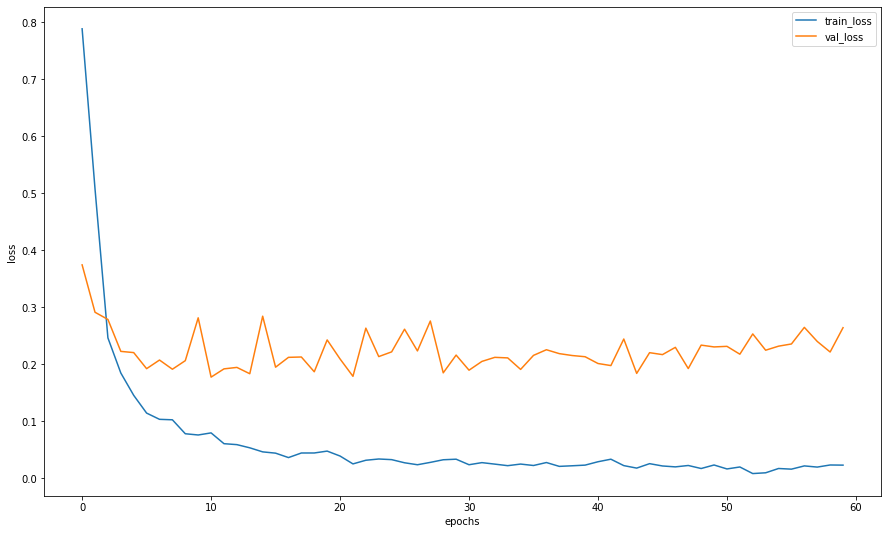

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Видно, что loss "застревает" на определённом уровне, однако преодолеть это у меня не вышло. Явного переобучения я также не заметил, так что пойдём дальше. Сделаем предсказания на всём валидационном датасете и посчитаем f1-score

In [ ]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(1000)]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in range(1000)]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.965

Кажется странным, но на тестовой выборке, которая сдавалась в итоге в kaggle, скор во всех попытках получился значительно выше

Посмотрим на случайных картинках, что предсказывает модель и насколько она уверена в этих предсказаниях

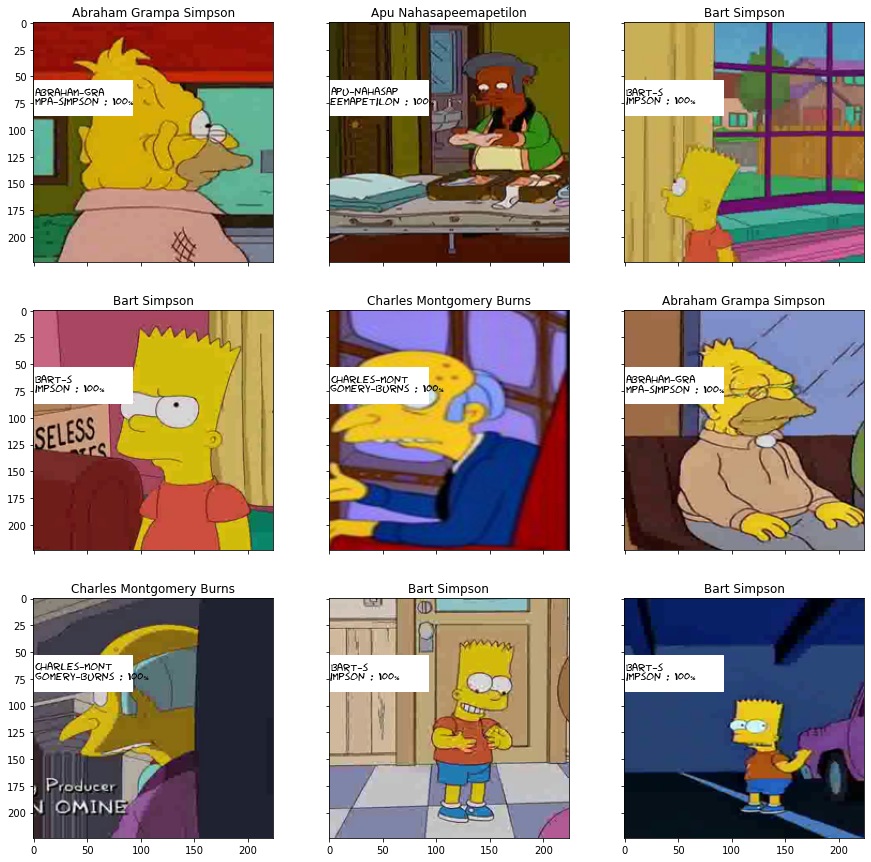

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),92,33,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=11, color='black',fontweight='bold')

### 4. Делаем предсказания на тестовом датасете

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/final.csv', index=False)